In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!which python

/pscratch/sd/x/xju/venv/llm/bin/python


In [3]:
!python --version 

Python 3.9.7


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.1.0+cu118
True


In [5]:
import sys
sys.path.append("..")

from lightning.fabric import Fabric
from model import GPTConfig, GPT
from omegaconf import DictConfig
from omegaconf import OmegaConf

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt

from more_itertools import pairwise

In [5]:
# a model with a wrong vacob size.
ckpt_path = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/outputs/2023-11-02/11-38-10/best.ckpt"
model_config_str = """
block_size: 1024
vocab_size: 50304
n_layer: 12
n_head: 16
n_embd: 256
dropout: 0
bias: False
"""
model_config = OmegaConf.create(model_config_str)

In [48]:
# a model trained with fixed-length sequences
# ckpt_path = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/outputs/2023-11-09/18-31-38/best.ckpt"

ckpt_path = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/outputs/2023-11-10/14-33-53/checkpoints/ckpt-8000.ckpt"
is_compiled = True
model_config_str = """
block_size: 22
vocab_size: 18737
n_layer: 12
n_head: 16
n_embd: 1024
dropout: 0
bias: False
"""
model_config = OmegaConf.create(model_config_str)

In [8]:
gpt_config = GPTConfig(**model_config)
model = GPT(gpt_config)

if is_compiled:
    model = torch.compile(model)

In [9]:
optim_yaml = """
learning_rate: 1e-3 # max learning rate
max_iters: 600_000 # total number of training iterations
weight_decay: 1e-1   # [TODO]
beta1: 0.9
beta2: 0.95
grad_clip_val: 1.0 # clip gradients at this value, or disable if == 0.0

# learning rate decay settings
decay_lr: True  # whether to decay the learning rate
warmup_iters: 2000  # how many steps to warm up for
lr_decay_iters: 600000  # should be ~= max_iters per Chinchilla
min_lr: 6e-5  # minimum learning rate, should be ~= learning_rate/10 per Chinchilla
"""
optim_config = OmegaConf.create(optim_yaml)
optimizer = model.configure_optimizers(optim_config, "cpu")

In [10]:
fabric = Fabric(precision="bf16-mixed")
fabric.launch()

/pscratch/sd/x/xju/venv/llm/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /pscratch/sd/x/xju/venv/llm/lib/python3.9/site-packa ...
Using bfloat16 Automatic Mixed Precision (AMP)
You are using a CUDA device ('NVIDIA A100-PCIE-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


In [11]:
model, optimizer = fabric.setup(model, optimizer)

In [12]:
state = {
    "model": model,
    "optimizer": optimizer,
}
fabric.load(ckpt_path, state)

{}

In [100]:
val_data_filename = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/data/trackml/v7_evt100_val.bin"
val_data = np.memmap(val_data_filename, dtype=np.uint16, mode='r')

In [13]:
val_data_filename = "/pscratch/sd/x/xju/LLMTracking/HEP-GPT/data/trackml_fixed_length/v1_evt10_val.bin"
val_data = np.memmap(val_data_filename, dtype=np.uint16, mode='r')

In [14]:
val_data.shape[0] / 22

81093.0

In [15]:
track_start_indices = np.argwhere(val_data==3).squeeze()
track_end_indices = np.argwhere(val_data==4).squeeze()

In [16]:
track_length = np.array([y-x for x,y in pairwise(track_start_indices)])
np.argwhere(track_length != 22)

array([], shape=(0, 1), dtype=int64)

In [17]:
num_of_hits = track_end_indices - track_start_indices

In [18]:
num_of_hits[num_of_hits > 8].shape

(69894,)

Text(0, 0.5, 'Tracks')

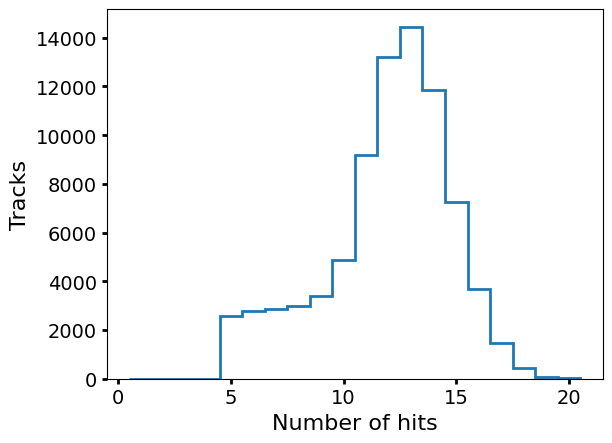

In [19]:
plt.hist(num_of_hits, bins=20, range=(0.5, 20.5), histtype="step", lw=2)
plt.xlabel("Number of hits")
plt.ylabel("Tracks")

In [37]:
num_of_seed_hits = 4
block_size = 22
UNKNOWN_TOKEN = 8

In [38]:
all_tracks = [val_data[x:y+1] for x,y in zip(track_start_indices, track_end_indices)]
seeds = np.array([track[:num_of_seed_hits+1] for track in all_tracks]).astype("int")

In [ ]:
seeds.shape

In [22]:
detector_path = "/global/cfs/cdirs/m3443/data/trackml-codalab/detector.csv"
detector = pd.read_csv(detector_path)

In [23]:
def plot(ax1, ax2, track: np.ndarray, *args, **kwargs) -> None:
    """Plot a track from different views"""
    minorsize = 14
    fontsize = 16

    if track.shape[0] != 3:
        raise ValueError("Track must have 3 columns for x, y, and z.")

    if 'lw' not in kwargs:
        kwargs['lw'] = 2

    x = track[0]
    y = track[1]
    z = track[2]
    r = np.sqrt(x**2 + y**2)

    # plot r vs z
    ax1.plot(z, r, *args, **kwargs)
    ax1.set_xlabel("z [m]", fontsize=fontsize)
    ax1.set_ylabel("r [m]", fontsize=fontsize)
    ax1.tick_params(axis='both', which='major', labelsize=minorsize)
    ax1.set_xlim(-3200, 3200)
    ax1.set_ylim(0, 1100)
    
    # plot x vs y
    ax2.plot(x, y, *args, **kwargs)
    ax2.set_xlabel("x [m]", fontsize=fontsize)
    ax2.set_ylabel("y [m]", fontsize=fontsize)
    ax2.tick_params(axis='both', which='major', labelsize=minorsize)
    ax2.set_xlim(-1000, 1000)
    ax2.set_ylim(-1000, 1000)

In [40]:
true_track, seed_track

(memmap([    3,   862,  1215,  1216,  1805,  2795,  2796,  5476,  6549,
          8069, 10020, 10122, 14125, 17247, 17399,     4,     7,     7,
             7,     7,     7,     7], dtype=uint16),
 array([   3,  862, 1215, 1216, 1805]))

In [43]:
trk_idx = 27

num_of_seed_hits = 7

true_track = val_data[trk_idx * block_size: (trk_idx + 1) * block_size]
seed_track = true_track[:num_of_seed_hits + 1].astype("int32")
seed_tokens = torch.from_numpy(seed_track.reshape([1, -1])).to("cuda")



def get_position(module_ids):
    array = np.array([detector.iloc[idx - UNKNOWN_TOKEN - 1][["cx", "cy", "cz"]].values.tolist() for idx in module_ids if idx > UNKNOWN_TOKEN])
    return array.T

seed_positions = get_position(seed_track)
true_track_positions = get_position(true_track)

In [34]:
seed_track, seed_positions, len([x for x in true_track if x > UNKNOWN_TOKEN])

(array([   3,  862, 1215, 1216, 1805]),
 array([[-26.8149, -63.2779, -55.4635, -99.0567],
        [-17.9171, -33.8227, -45.5177, -59.8819],
        [-35.    ,  35.    ,  35.    ,  35.    ]]),
 14)

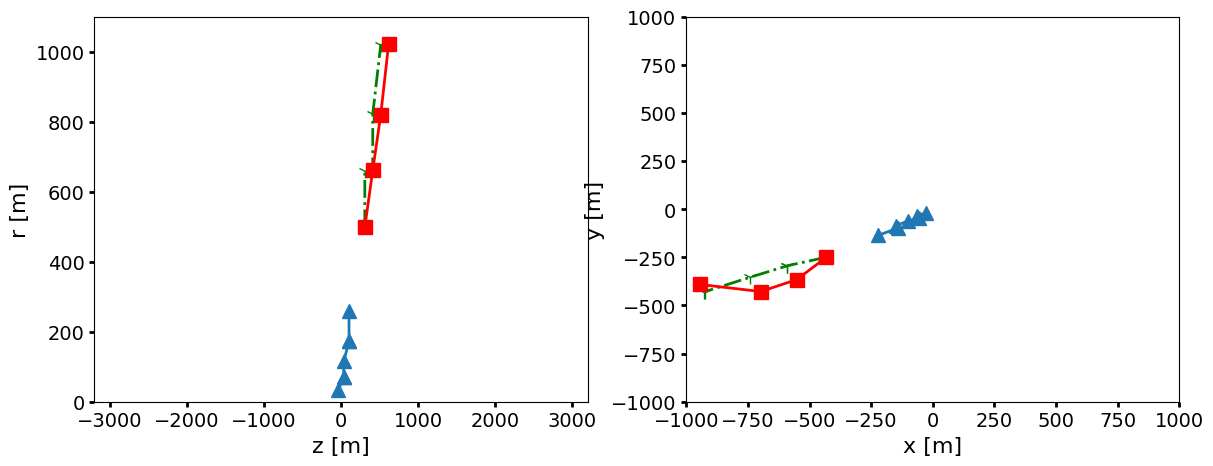

In [47]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot(ax1, ax2, seed_positions, '-^', ms=10, label="seed")
plot(ax1, ax2, true_track_positions[:, num_of_seed_hits + 1:], 'g-.1', ms=10, label="truth")


sim_track = model.generate(seed_tokens, block_size - num_of_seed_hits - 1).cpu().numpy()[0]
sim_track_positions = get_position(sim_track)

plot(ax1, ax2, sim_track_positions[:, num_of_seed_hits + 1:], 'r-s', ms=10, label="prediction")

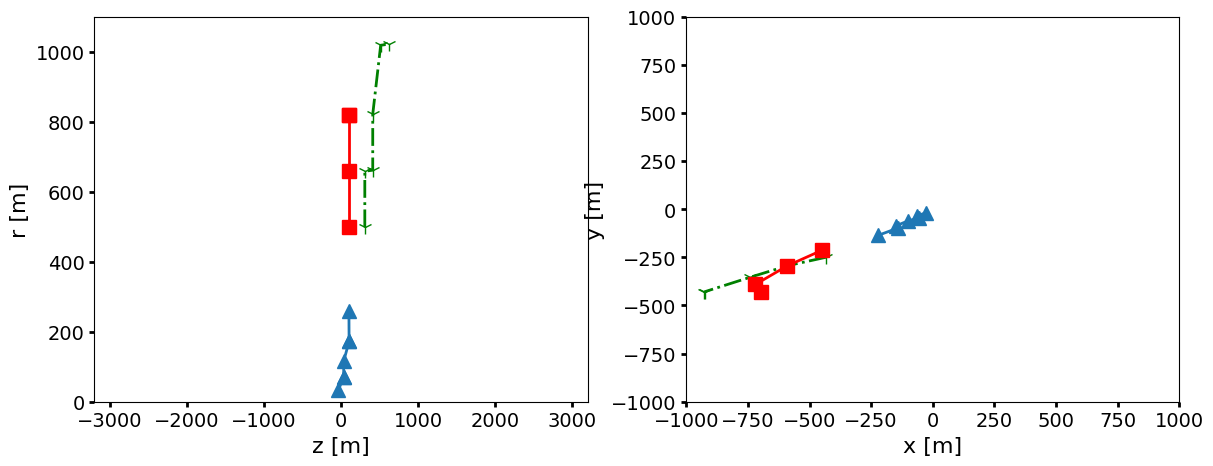

In [46]:
fig = plt.figure(figsize=(14, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
plot(ax1, ax2, seed_positions, '-^', ms=10, label="seed")
plot(ax1, ax2, true_track_positions[:, num_of_seed_hits + 1:], 'g-.1', ms=10, label="truth")


sim_track = model.generate(seed_tokens, block_size - num_of_seed_hits - 1).cpu().numpy()[0]
sim_track_positions = get_position(sim_track)

plot(ax1, ax2, sim_track_positions[:, num_of_seed_hits + 1:], 'r-s', ms=10, label="prediction")

In [59]:
def evaluate(trial_idx):
    sim_track = model.generate(seed_tokens, block_size - num_of_seed_hits - 1).cpu().numpy()[0]
    sim_track_positions = get_position(sim_track)

    fig = plt.figure(figsize=(14, 5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)

    plot(ax1, ax2, seed_positions, '-^', ms=10, label="seed")
    plot(ax1, ax2, true_track_positions[:, num_of_seed_hits + 1:], 'g-.1', ms=10, label="truth")
    plot(ax1, ax2, sim_track_positions[:, num_of_seed_hits + 1:], 'r-s', ms=10, label="prediction")
    
    ax1.legend()
    plt.savefig(f"eval_{trial_idx:03d}.png")
    plt.close()

In [60]:
evaluate(0)

In [138]:
seed_positions.shape, true_track_positions.shape

((3, 4), (3, 22))

In [64]:
%%time
for idx in range(20):
    evaluate(idx)

CPU times: user 5.92 s, sys: 2.72 s, total: 8.64 s
Wall time: 5.99 s


In [147]:
sim_track = model.generate(seed_tokens, 18).cpu().numpy()[0]
sim_track

array([    3,   880,  1251,  1863,  1914,  1915,  2881,  5559,  6664,
        8307, 10532, 18152, 18341, 18437,     4,     7,     7,     7,
           7,     7,     7,     7])